In [1]:
from functions import *

2024-11-19 12:35:14.666053: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-19 12:35:14.686476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-19 12:35:14.692756: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-19 12:35:14.709219: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-19 12:35:16.067982: W tensorflow/compiler/tf2

In [2]:
import matplotlib.pyplot as plt
import glob
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import geopandas as gpd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import glob
import time
from datetime import datetime
from collections import Counter
from PIL import Image

# Visualize one experiment

In [3]:
model='baseline_CNN'
exp = 26

#### Experiment details

In [4]:
df=pd.read_excel(f'../results/{model}_results.xlsx')
df
#res[res.Experiment == exp]

,Experiment,RMSE,Variables,Input,Split,nº samples,Batch size,Epochs,Date,Time,Duration,Loss,Resolution
0,0,5.770745,lst,47 rivers,random,968,32,300,2024-11-14,11:39:13,1500.29,Physics-guided,128
1,1,6.100804,lst,47 rivers,random,968,32,300,2024-11-14,12:03:29,1452.81,RMSE,128
2,2,5.495109,lst,47 rivers,random,968,64,300,2024-11-14,12:26:37,1386.13,Physics-guided,128
3,3,5.335479,lst,47 rivers,random,968,64,300,2024-11-14,12:47:43,1261.77,RMSE,128
4,4,5.383340,lst,47 rivers,random,968,128,300,2024-11-14,13:05:31,1066.09,Physics-guided,128
5,5,5.363269,lst,47 rivers,random,968,128,300,2024-11-14,13:22:10,996.08,RMSE,128
6,6,5.442771,lst,80 rivers,random,1628,128,300,2024-11-14,14:51:45,971.66,Physics-guided,128
7,7,5.335798,lst,80 rivers,random,1628,128,300,2024-11-14,15:07:44,955.82,RMSE,128
8,8,5.448506,lst,80 rivers,random,1628,128,300,2024-11-14,15:26:18,868.23,Physics-guided,64
9,9,5.267368,lst,80 rivers,random,1628,128,300,2024-11-14,15:40:22,842.37,RMSE,64


In [7]:
errors_df = pd.read_csv(f'../results/error_logs/{model}_exp_{exp}.csv')

#### Learning curve

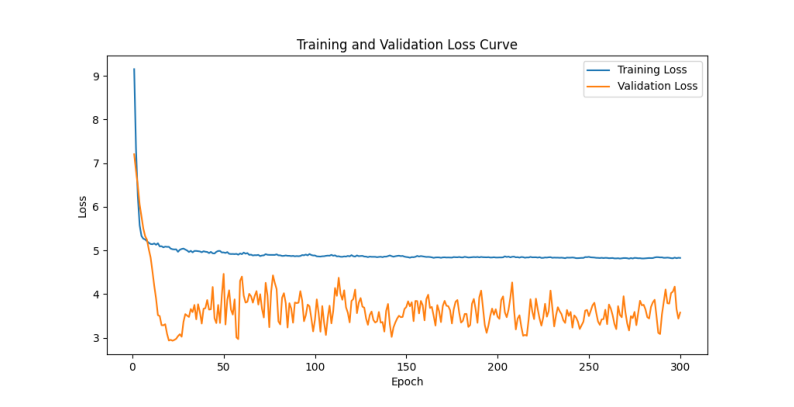

In [19]:
image_path = f'../results/learning_curves/{model}_exp_{exp}.png'
image = Image.open(image_path)
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')
plt.show()


#### Error log

In [7]:
errors_df_filt = errors_df[errors_df['epoch'] <= 100]

In [8]:
errors_df_filt

,epoch,month,error
0,1,8,10.663290
1,1,2,5.325575
2,1,5,10.576869
3,1,11,7.436599
4,1,6,9.519579
...,...,...,...
130395,100,11,3.144165
130396,100,6,4.164575
130397,100,5,1.484890
130398,100,12,6.095383


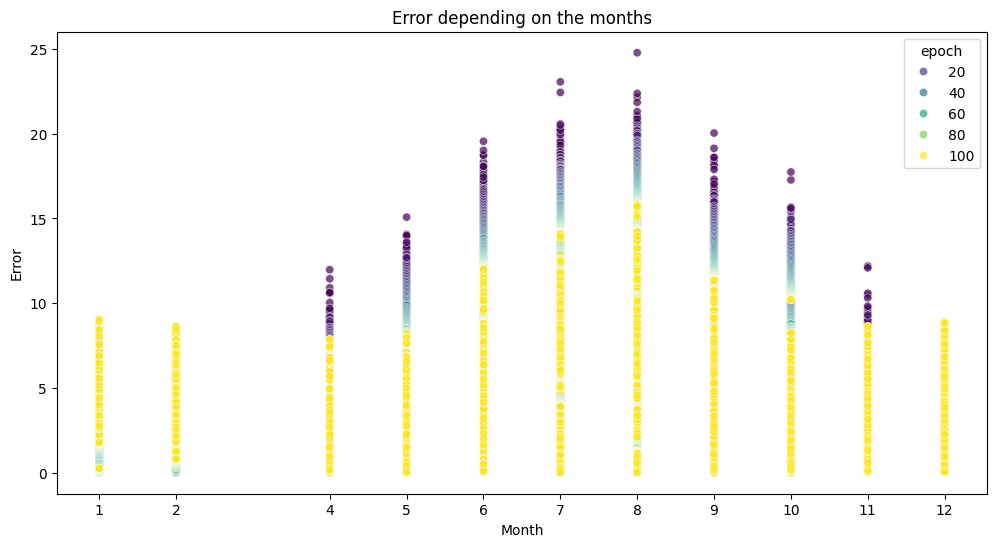

In [10]:
plt.figure(figsize=(12, 6))
sns.scatterplot(data=errors_df_filt, x="month", y="error", hue="epoch", palette="viridis", alpha=0.7)
plt.xticks(ticks=sorted(errors_df_filt["month"].unique()))
plt.title("Error depending on the months")
plt.xlabel("Month")
plt.ylabel('Error')
plt.show()

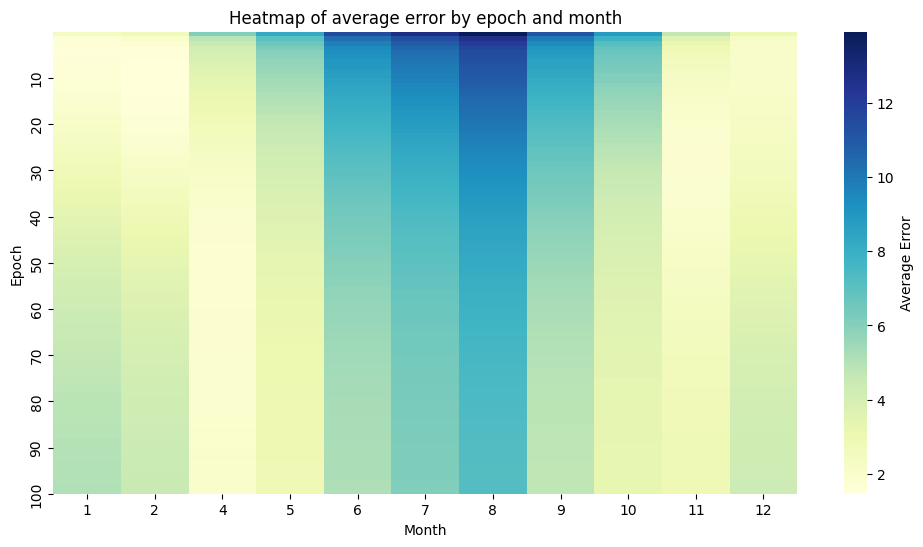

In [11]:
epochs = len(errors_df_filt.epoch.unique())
pivot_table = errors_df_filt.pivot_table(values="error", index="epoch", columns="month", aggfunc="mean")
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap="YlGnBu", cbar_kws={'label': 'Average Error'})
if epochs == 10:
    ticks = range(epochs + 1)
    labelss = [str(i) for i in range(epochs + 1)]
else:
    ticks = [i for i in range(10, epochs + 1, 10)]
    labelss = [str(i) for i in range(10, epochs + 1, 10)]
plt.yticks(ticks=ticks,labels=labelss)
plt.title("Heatmap of average error by epoch and month")
plt.xlabel("Month")
plt.ylabel("Epoch")
plt.show()

In [20]:
frecuencia_por_mes = errors_df['month'].value_counts().sort_index()

print(frecuencia_por_mes)

month
1     10000
2      8200
4     10900
5     11300
6     10400
7      9600
8     10700
9     11300
10    10800
11    16700
12     9200
Name: count, dtype: int64


# Analyze model experiments

### Compare RMSE for all baseline experiments

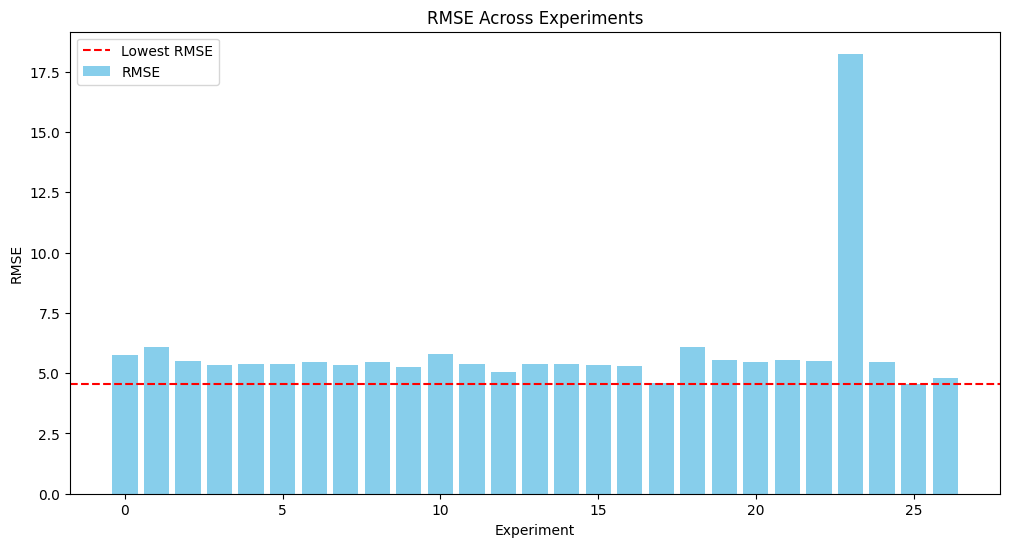

In [24]:
plt.figure(figsize=(12, 6))
plt.bar(df['Experiment'], df['RMSE'], color='skyblue', label="RMSE")
plt.axhline(y=df['RMSE'].min(), color='red', linestyle='--', label="Lowest RMSE")
plt.xlabel('Experiment')
plt.ylabel('RMSE')
plt.title('RMSE Across Experiments')
plt.legend()
plt.show()

### Analyze RMSE by Variable Sets

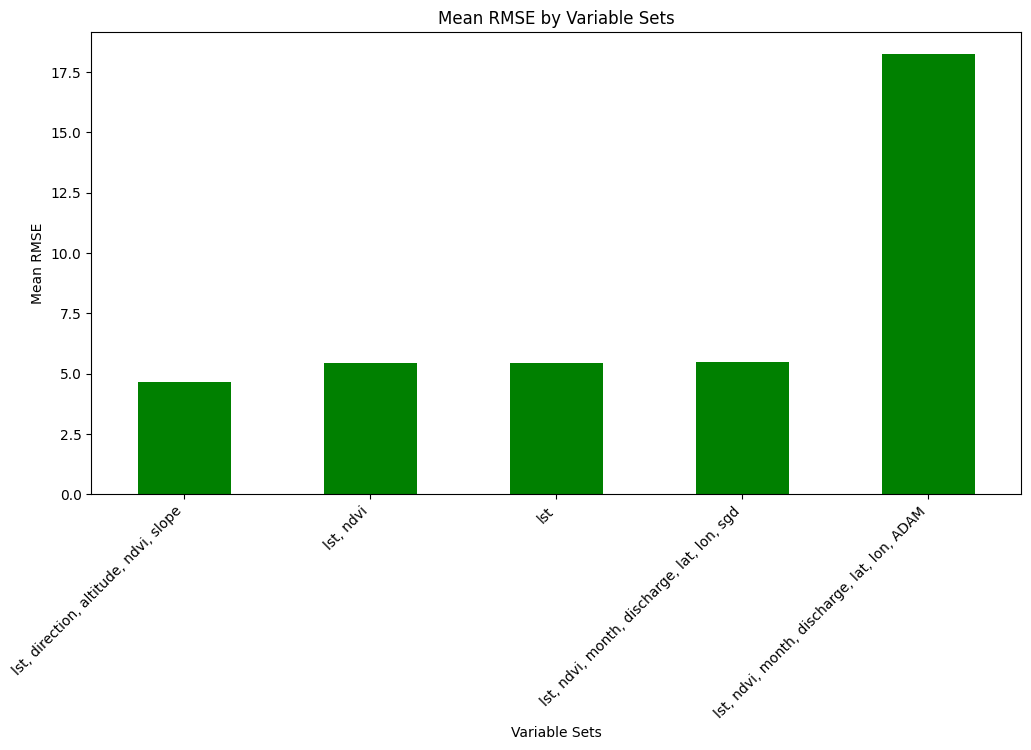

In [25]:
# Group by Variables and calculate mean RMSE
variables_rmse = df.groupby('Variables')['RMSE'].mean().sort_values()

# Plot mean RMSE for each variable set
plt.figure(figsize=(12, 6))
variables_rmse.plot(kind='bar', color='green')
plt.xlabel('Variable Sets')
plt.ylabel('Mean RMSE')
plt.title('Mean RMSE by Variable Sets')
plt.xticks(rotation=45, ha='right')
plt.show()


### Analyze RMSE by Batch Size

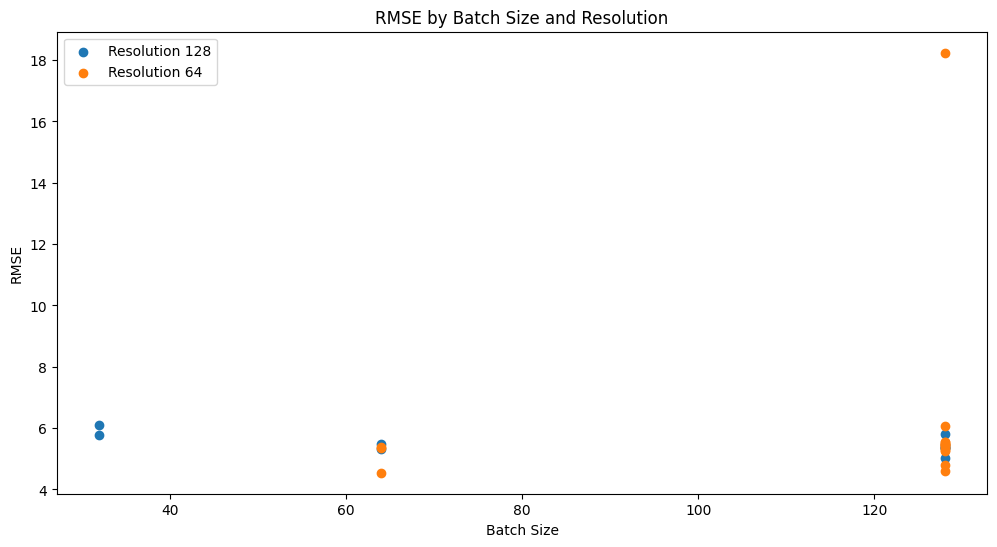

In [26]:
# Plot RMSE by Batch Size
plt.figure(figsize=(12, 6))
for resolution in df['Resolution'].unique():
    subset = df[df['Resolution'] == resolution]
    plt.scatter(subset['Batch size'], subset['RMSE'], label=f"Resolution {resolution}")
plt.xlabel('Batch Size')
plt.ylabel('RMSE')
plt.title('RMSE by Batch Size and Resolution')
plt.legend()
plt.show()


Best Experiment:
     Experiment      RMSE                              Variables      Input  \
25          25  4.545609  lst, direction, altitude, ndvi, slope  74 rivers   

     Split  nº samples  Batch size  Epochs        Date      Time  Duration  \
25  random        1487          64     300  2024-11-18  15:44:15   1095.03   

    Loss  Resolution  
25  RMSE          64  


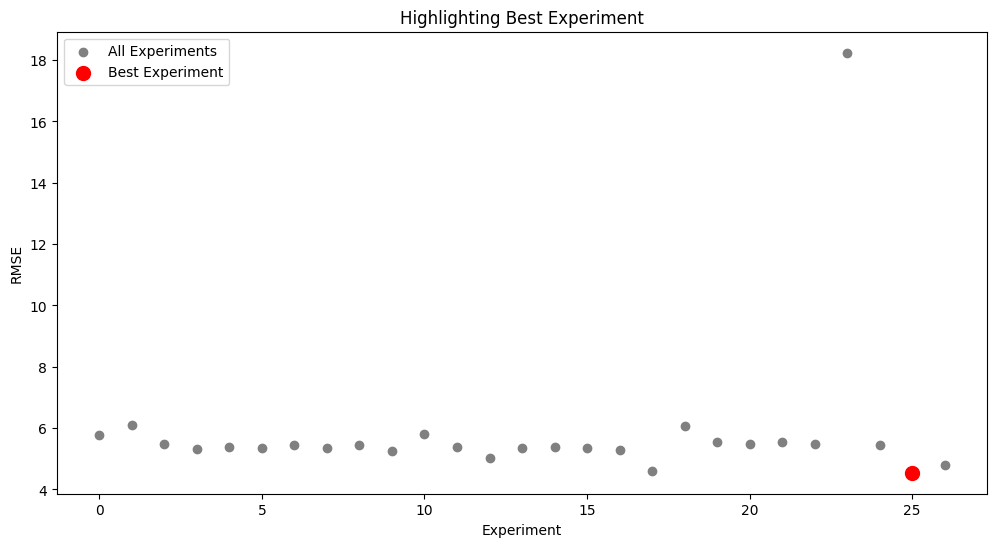

In [28]:
# Find the best experiment (lowest RMSE)
best_experiment = df[df['RMSE'] == df['RMSE'].min()]
print("Best Experiment:\n", best_experiment)

# Optional: Highlight best configurations
plt.figure(figsize=(12, 6))
plt.scatter(df['Experiment'], df['RMSE'], color='grey', label='All Experiments')
plt.scatter(best_experiment['Experiment'], best_experiment['RMSE'], color='red', label='Best Experiment', s=100)
plt.xlabel('Experiment')
plt.ylabel('RMSE')
plt.title('Highlighting Best Experiment')
plt.legend()
plt.show()
